In [1]:
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T # May not be needed if using CLIP processor directly
from transformers import CLIPProcessor, CLIPModel
import numpy as np # Added for reshaping if needed


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("✅ CLIP model loaded successfully!")

# ✨ Add this line to move the entire model to the GPU
clip_model.to(device)
# clip_model.eval() # Set model to evaluation mode



/home/bongo/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/bongo/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Using device: cuda


2025-11-06 11:47:37.751637: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 11:47:37.776702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-06 11:47:37.776726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-06 11:47:37.777729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-06 11:47:37.783517: I tensorflow/core/platform/cpu_feature_guar

✅ CLIP model loaded successfully!


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [2]:

def get_clip_similarity_map(
    image_path: str,
    model: CLIPModel,
    processor: CLIPProcessor,
    object_name: str,
    device: str
) -> (torch.Tensor | None, tuple | None):
    """
    CLIP 모델을 사용하여 이미지의 각 패치와 주어진 객체 텍스트 간의
    코사인 유사도 맵(패치별 점수)을 추출합니다.

    Args:
        image_path: 이미지 파일 경로.
        model: 사전 로드된 CLIP 모델.
        processor: 사전 로드된 CLIP 프로세서.
        object_name: 유사도를 계산할 객체 이름 (텍스트).
        device: 'cuda' 또는 'cpu'.

    Returns:
        - 유사도 맵 텐서 (shape: [1, num_patches]) - 각 패치에 대한 유사도 점수.
        - 원본 이미지 크기 (width, height) 튜플.
        에러 발생 시 (None, None) 반환.
    """



    image = Image.open(image_path).convert('RGB')
    original_size = image.size # (width, height)

    # --- Image and Text Preprocessing ---
    inputs = processor(
        text=[f"a photo of a {object_name}"], # Use a descriptive prompt
        images=image,
        return_tensors="pt",
        padding=True
    ).to(device)

    # --- Feature Extraction ---
    with torch.no_grad():
        # Get text features (projected)
        text_outputs = model.text_model(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask']
        )
        # Use the final projected text embedding (index [1] is often pooled output)
        text_features = model.text_projection(text_outputs[1])
        text_features = F.normalize(text_features, p=2, dim=-1) # Shape: (1, D)

        # Get image patch features (projected)
        img_outputs = model.vision_model(
            pixel_values=inputs['pixel_values'],
            output_hidden_states=True
        )
        patch_tokens_unprojected = img_outputs.last_hidden_state[:, 1:, :] # Exclude CLS
        patch_tokens_projected = model.visual_projection(patch_tokens_unprojected) # Project
        patch_tokens_norm = F.normalize(patch_tokens_projected, p=2, dim=-1) # Shape: (1, num_patches, D)

        # --- Cosine Similarity Calculation ---
        # Reshape text features for matmul: (1, D) -> (1, D, 1)
        text_features_exp = text_features.unsqueeze(-1)

        # Calculate similarity: (1, N_patches, D) @ (1, D, 1) -> (1, N_patches, 1)
        # Squeeze the last dimension to get (1, N_patches) as in the working example
        cosine_similarities = torch.matmul(patch_tokens_norm, text_features_exp).squeeze(-1) # Shape: (1, num_patches)
        # --- Reshape for Visualization ---
        num_patches = patch_tokens_norm.shape[1]
        # Determine grid size (e.g., 7x7 for ViT-B/32, 16x16 for ViT-B/14)
        grid_size = int(np.sqrt(num_patches))
        if grid_size * grid_size != num_patches:
             raise ValueError("Number of patches is not a perfect square.")

        similarity_map_2d = cosine_similarities.reshape(grid_size, grid_size).cpu().numpy()

        # --- Upscale Heatmap ---
        # Normalize map values to 0-1 range for visualization
        similarity_map_normalized = (similarity_map_2d - similarity_map_2d.min()) / (similarity_map_2d.max() - similarity_map_2d.min())
    # --- ✨ 반전 로직 추가 (Invert the map) ---
        inverted_heatmap_small = 1.0 - similarity_map_normalized

        # --- Upscale Heatmap ---
        heatmap = np.array(Image.fromarray(inverted_heatmap_small).resize(original_size, resample=Image.Resampling.BILINEAR))


    
    # --- 3. Return ---
    # Return the similarity scores for each patch and the original image size
    return heatmap

In [31]:
def get_clip_similarity_map(
    image_path: str, 
    model: CLIPModel, 
    processor: CLIPProcessor, 
    object_name: str, # Changed 'object' to 'object_name' to avoid conflict with type hint
    device: str
) -> (torch.Tensor | None, tuple | None):
    """
    CLIP 모델을 사용하여 이미지의 각 패치와 주어진 객체 텍스트 간의 
    코사인 유사도 맵을 추출합니다.

    Args:
        image_path: 이미지 파일 경로.
        model: 사전 로드된 CLIP 모델.
        processor: 사전 로드된 CLIP 프로세서.
        object_name: 유사도를 계산할 객체 이름 (텍스트).
        device: 'cuda' 또는 'cpu'.

    Returns:
        - 유사도 맵 텐서 (shape: [1, num_patches, 1]) - 원본 함수의 반환 형태와 유사하게 맞춤.
        - 원본 이미지 크기 (width, height) 튜플.
        에러 발생 시 (None, None) 반환.
    """
    if model is None or processor is None:
        print("Error: CLIP model or processor not loaded.")
        return None, None
        

    image = Image.open(image_path).convert('RGB')
    original_size = image.size # (width, height)

    # --- Image and Text Preprocessing ---
    # Note: CLIP processor handles resizing, tensor conversion, and normalization internally.
    inputs = processor(
        text=[f"a photo of a {object_name}"], # Use a descriptive prompt
        images=image, 
        return_tensors="pt", 
        padding=True
    ).to(device)

    # --- Feature Extraction ---

    with torch.no_grad():
        # ✨ Pass only text inputs to the text model
        text_outputs = model.text_model(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask']
            # Add other text-specific args like position_ids if needed by your model version
        )
        text_features = text_outputs.pooler_output

        # ✨ Pass only image inputs to the vision model
        img_outputs = model.vision_model(
            pixel_values=inputs['pixel_values'],
            output_hidden_states=True
        )
        patch_tokens_unprojected = img_outputs.last_hidden_state[:, 1:, :]

        # Apply visual projection
        patch_tokens_projected = model.visual_projection(patch_tokens_unprojected)

        # --- Cosine Similarity Calculation ---
        patch_tokens_norm = F.normalize(patch_tokens_projected, p=2, dim=-1)
        text_features_norm = F.normalize(text_features, p=2, dim=-1)
        text_features_exp = text_features_norm.unsqueeze(-1)
        cosine_similarities = torch.matmul(patch_tokens_norm, text_features_exp)

    # --- 3. Return ---
    return cosine_similarities.cpu(), original_size



In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import timm
import torchvision.transforms as T
from sklearn.cluster import KMeans
from VLM_model_dot import  MetricsTracker

import os
from file_managing import (
    load_selected_samples,
    get_actual_path,
    get_gt_path,
)

def load_vlm_heatmap(heatmap_path: str, target_size: tuple) -> np.ndarray:
    """저장된 VLM 히트맵을 불러옵니다."""
    heatmap_img = Image.open(heatmap_path).convert('L')
    heatmap_img = heatmap_img.resize(target_size, resample=Image.Resampling.BILINEAR)
    heatmap_array = np.array(heatmap_img).astype(np.float32) / 255.0
    return heatmap_array




In [22]:
from torchvision import transforms
import torch.nn.functional as F

def load_ground_truth( gt_path):
    """
    Load and process ground truth image
    Args:
        gt_path (str): Path to the ground truth image
    Returns:
        torch.Tensor: Processed ground truth tensor normalized to [0, 1]
    """
    try:
        # Load the ground truth image
        gt_img = Image.open(gt_path)

        # Convert to grayscale if image is RGB
        if gt_img.mode == 'RGB':
            gt_img = gt_img.convert('L')

        # Convert to tensor
        gt_tensor = transforms.ToTensor()(gt_img).squeeze(0)

        # Normalize to [0, 1]
        if gt_tensor.max() > 0:
            gt_tensor = (gt_tensor - gt_tensor.min()) / (gt_tensor.max() - gt_tensor.min())

        return gt_tensor
    except Exception as e:
        print(f"⚠️ Failed to load ground truth image: {str(e)}")
        return None    

In [23]:
def calculate_metrics( pred_heatmap, gt_map):
    """
    Calculate comparison metrics between predicted heatmap and GT (following original metric.py)
    Args:
        pred_heatmap (torch.Tensor): Predicted heatmap
        gt_map (torch.Tensor): Ground truth map
    Returns:
        dict: Dictionary containing KLD, SIM, and NSS metrics
    """
    # Ensure inputs are proper tensors
    if not isinstance(pred_heatmap, torch.Tensor):
        pred_heatmap = torch.tensor(pred_heatmap)
    if not isinstance(gt_map, torch.Tensor):
        gt_map = torch.tensor(gt_map)

    # Flatten tensors and add batch dimension for compatibility
    pred = pred_heatmap.flatten().float().unsqueeze(0)  # [1, H*W]
    gt = gt_map.flatten().float().unsqueeze(0)          # [1, H*W]

    eps = 1e-10

    # Calculate KLD following original implementation
    # Normalize to probability distributions
    pred_norm = pred / pred.sum(dim=1, keepdim=True)
    gt_norm = gt / gt.sum(dim=1, keepdim=True)
    pred_norm += eps
    kld = F.kl_div(pred_norm.log(), gt_norm, reduction="batchmean").item()

    # Calculate SIM following original implementation
    pred_sim = pred / pred.sum(dim=1, keepdim=True)
    gt_sim = gt / gt.sum(dim=1, keepdim=True)
    sim = torch.minimum(pred_sim, gt_sim).sum().item() / len(pred_sim)

    # Calculate NSS following original implementation
    # First normalize by max values
    pred_nss = pred / pred.max(dim=1, keepdim=True).values
    gt_nss = gt / gt.max(dim=1, keepdim=True).values

    # Calculate z-score for prediction
    std = pred_nss.std(dim=1, keepdim=True)
    u = pred_nss.mean(dim=1, keepdim=True)
    smap = (pred_nss - u) / (std + eps)

    # Create fixation map from GT
    fixation_map = (gt_nss - torch.min(gt_nss, dim=1, keepdim=True).values) / (
        torch.max(gt_nss, dim=1, keepdim=True).values - torch.min(gt_nss, dim=1, keepdim=True).values + eps)
    fixation_map = (fixation_map >= 0.1).float()

    # Calculate NSS
    nss_values = smap * fixation_map
    nss = nss_values.sum(dim=1) / (fixation_map.sum(dim=1) + eps)
    nss = nss.mean().item()

    return {
        'KLD': kld,
        'SIM': sim,
        'NSS': nss
    }

In [34]:
metrics_tracker_dino = MetricsTracker(name="only_ego")

json_path = os.path.join("selected_samples.json")
data = load_selected_samples(json_path)
missing_gt = 0
processed_count = 0

# Get total number of samples
total_samples = len(data['selected_samples'])

# Process each sample
print(f"Processing {total_samples} samples...")
print("=" * 50)    
for pair_key, sample_info in data["selected_samples"].items():
    processed_count += 1
    print(f"--- Start  {processed_count}  / {total_samples}", "-"*80) 
    original_image_path = sample_info['image_path'].replace("${AGD20K_PATH}",'/home/DATA/AGD20K')
    
    file_name = os.path.basename(sample_info['image_path'])
    action_name = sample_info['image_path'].split('/')[4]
    if file_name.count("_") ==1:
        item_name = file_name.split("_")[0]
    else:
        item_name = file_name.split("_")[0] + "_" + file_name.split("_")[1]
    AGD20K_PATH = '/home/DATA/AGD20K'
    vlm_heatmap_path = f"/home/bongo/porter_notebook/research/new_qwen_AG/32B_dino_1_power2/heatmaps/{file_name.split('.')[0]}_{action_name}_heatmap.jpg"
    gt_path =  f"{AGD20K_PATH}/Seen/testset/GT/{action_name}/{item_name}/{file_name.split('.')[0]}.png"
    dot_path = f"/home/bongo/porter_notebook/research/new_qwen_AG/32B_dino_1_power2/dots_only//{file_name.split('.')[0]}_{action_name}_dots.jpg"
    print(item_name, action_name, file_name)
    output_path = f"dino_fusion/{file_name.split('.')[0]}_{action_name}.png"
    # --- 2. VLM 히트맵 로드 및 DINO 특징 추출 ---
    original_image = Image.open(original_image_path).convert('RGB')
    dot_image = Image.open(dot_path).convert('RGB')
    vlm_heatmap_image =  Image.open(vlm_heatmap_path).convert('RGB')
#     print("Loading VLM heatmap...")
    vlm_heatmap = load_vlm_heatmap(vlm_heatmap_path, original_image.size)


    clip_heatmap = get_clip_similarity_map(
        original_image_path,
        clip_model, # Pass the model object (now on GPU)
        clip_processor,
        item_name,
        device
    )


        
    vlm_heatmap = vlm_heatmap + vlm_heatmap.mean()*0.75
#     weighted_dino_heatmap = clip_heatmap
    weighted_dino_heatmap = clip_heatmap[0].numpy()
    vlm_fused_heatmap = vlm_heatmap * weighted_dino_heatmap

    
    # Calculate metrics if GT is available
    metrics = None
    gt_map = load_ground_truth(gt_path)
    if gt_map is not None:
        metrics_dino  = calculate_metrics(vlm_fused_heatmap, gt_map)
        metrics_tracker_dino.update(metrics_dino)
    else:
        print("NO GT!!!")
        continue
    metrics_tracker_dino.print_metrics(metrics_dino, vlm_heatmap_path.split('/')[-1])
    
    # --- 4. 결과 시각화 ---
    # ✨ 레이아웃을 1x4에서 1x5로 변경하고, figsize을 조정합니다.
    fig, ax = plt.subplots(1, 6, figsize=(25, 5))

    # --- Plot 1: 원본 이미지 (ax[0]) ---
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # --- ✨ Plot 5: 최종 퓨전 히트맵 (기존 ax[3] -> ax[4]로 이동) ---
    ax[1].imshow(dot_image)
    ax[1].set_title('Dot image')
    ax[1].axis('off')
    
    # --- Plot 2: dot 히트맵 (ax[1]) ---
    ax[2].imshow(original_image)
    ax[2].imshow(vlm_heatmap_image , cmap='jet', alpha=0.5)
    ax[2].set_title('dot (Input)')
    ax[2].axis('off')

    # --- Plot 2: VLM 히트맵 (ax[1]) ---
    ax[3].imshow(original_image)
    ax[3].imshow(vlm_fused_heatmap, cmap='jet', alpha=0.5)
    ax[3].set_title('VLM Heatmap (Input)')
    ax[3].axis('off')
    
    # --- ✨ Plot 3: DINO 원본 히트맵 (새로 추가된 부분) ---
    # 이 dino_attention_heatmap 변수는 클러스터링 전에 미리 계산해 두어야 합니다.
    # (예: dino_attention_heatmap = generate_dino_heatmap(original_image_path, dino_model) )
    ax[4].imshow(original_image)
    ax[4].imshow(clip_heatmap, cmap='jet', alpha=0.5)
    ax[4].set_title('clip_heatmap')
    ax[4].axis('off')


    # --- ✨ Plot 5: 최종 퓨전 히트맵 (기존 ax[3] -> ax[4]로 이동) ---
    ax[5].imshow(original_image)
    ax[5].imshow(gt_map, cmap='jet', alpha=0.5)
    ax[5].set_title('GT')
    ax[5].axis('off')
#     전체 레이아웃 정리 및 출력
    plt.tight_layout()
    plt.show()
    break
    # --- 5. 최종 퓨전 히트맵 이미지로 저장 ---
#     fused_heatmap_img = Image.fromarray((fused_heatmap * 255).astype(np.uint8))
#     fused_heatmap_img.save(output_path)
#     print(f"Fused heatmap saved to {output_path}")


Processing 123 samples...
--- Start  1  / 123 --------------------------------------------------------------------------------
skis jump skis_002829.jpg


ValueError: operands could not be broadcast together with shapes (1500,561) (1,49,1) 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

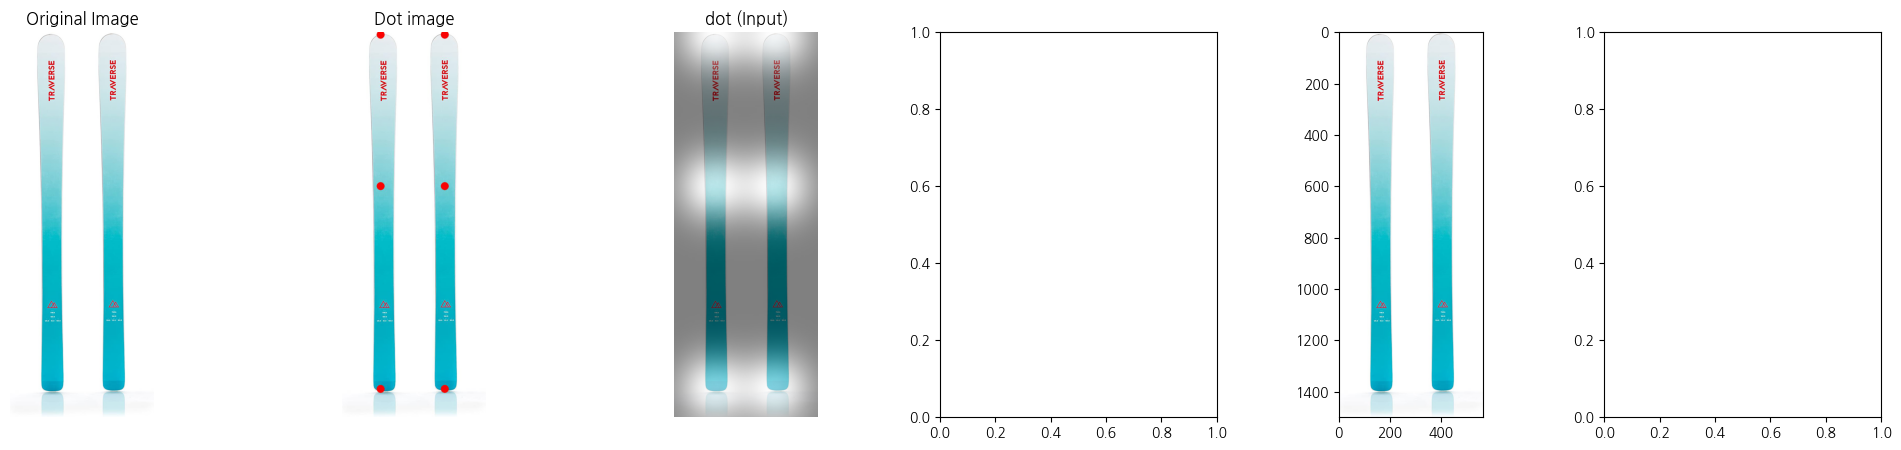

In [33]:
    # --- 4. 결과 시각화 ---
    # ✨ 레이아웃을 1x4에서 1x5로 변경하고, figsize을 조정합니다.
    fig, ax = plt.subplots(1, 6, figsize=(25, 5))

    # --- Plot 1: 원본 이미지 (ax[0]) ---
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # --- ✨ Plot 5: 최종 퓨전 히트맵 (기존 ax[3] -> ax[4]로 이동) ---
    ax[1].imshow(dot_image)
    ax[1].set_title('Dot image')
    ax[1].axis('off')
    
    # --- Plot 2: dot 히트맵 (ax[1]) ---
    ax[2].imshow(original_image)
    ax[2].imshow(vlm_heatmap_image , cmap='jet', alpha=0.5)
    ax[2].set_title('dot (Input)')
    ax[2].axis('off')

    
    # --- ✨ Plot 3: DINO 원본 히트맵 (새로 추가된 부분) ---
    # 이 dino_attention_heatmap 변수는 클러스터링 전에 미리 계산해 두어야 합니다.
    # (예: dino_attention_heatmap = generate_dino_heatmap(original_image_path, dino_model) )
    ax[4].imshow(original_image)
    ax[4].imshow(clip_heatmap, cmap='jet', alpha=0.5)
    ax[4].set_title('clip_heatmap')
    ax[4].axis('off')